In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


D:\myd\ac\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
train=pd.read_csv('D:/happiness/train.csv')
test=pd.read_csv('D:/happiness/test.csv')

In [4]:
print train.head()
print train.shape
print test.head()
print test.shape

   User_ID                                        Description  \
0  id10326  The room was kind of clean but had a VERY stro...   
1  id10327  I stayed at the Crown Plaza April -- - April -...   
2  id10328  I booked this hotel through Hotwire at the low...   
3  id10329  Stayed here with husband and sons on the way t...   
4  id10330  My girlfriends and I stayed here to celebrate ...   

        Browser_Used Device_Used Is_Response  
0               Edge      Mobile   not happy  
1  Internet Explorer      Mobile   not happy  
2            Mozilla      Tablet   not happy  
3   InternetExplorer     Desktop       happy  
4               Edge      Tablet   not happy  
(38932, 5)
   User_ID                                        Description  \
0  id80132  Looking for a motel in close proximity to TV t...   
1  id80133  Walking distance to Madison Square Garden and ...   
2  id80134  Visited Seattle on business. Spent - nights in...   
3  id80135  This hotel location is excellent and the roo

In [8]:
le = preprocessing.LabelEncoder()
a=le.fit_transform(train['Is_Response'])

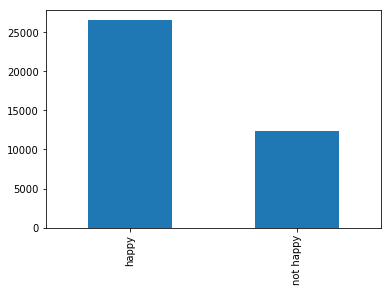

In [14]:
train['Is_Response'].value_counts().plot(kind='bar')

AttributeError: 'module' object has no attribute 'nunique'